#0. 환경 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/MyDrive/06_딥러닝/TermProject_딥러닝/한주호"

/content/drive/MyDrive/06_딥러닝/TermProject_딥러닝/한주호


In [ ]:
!pip install torchmetrics

In [ ]:
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchsummary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

from torchmetrics import Accuracy
from torchmetrics.aggregation import MeanMetric

import pandas as pd # 데이터프레임 형태를 다룰 수 있는 라이브러리
import numpy as np
from sklearn.model_selection import train_test_split # 전체 데이터를 학습 데이터와 평가 데이터로 분할

# ANN
import torch
from torch import nn, optim # torch 내의 세부적인 기능
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler # 데이터를 모델에 사용
import torch.nn.functional as F # torch 내의 세부적인 기능

# Cross Validation
from sklearn.model_selection import KFold

# Loss
from sklearn.metrics import accuracy_score

# Plot
import matplotlib.pyplot as plt # 시각화 도구

# 1. 하이퍼 파라미터

In [ ]:
# Build config
title = 'tree_disease'
device = 'cuda'
checkpoint_dir = 'checkpoints'
batch_size = 32
epochs = 45

#2. 데이터 처리

In [ ]:
# 데이터셋 경로
train_data_path = '/content/drive/MyDrive/06_딥러닝/딥러닝 TermProject/한주호/train'
test_data_path = '/content/drive/MyDrive/06_딥러닝/딥러닝 TermProject/한주호/test'

배경 처리 후 train data로 추가하려고 했으나 성능이 별로임

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 로드 후 RGB로 변환
image_bgr = cv2.imread('/content/drive/MyDrive/06_딥러닝/TermProject/느티나무 질병 데이터셋/train/disease/104_3.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# 사각형 좌표: 시작점의 x,y  ,넢이, 너비
print(image_rgb.shape[0])
print(image_rgb.shape[1])
rectangle = (0, 0, image_rgb.shape[0], image_rgb.shape[1])

# 초기 마스크 생성
mask = np.zeros(image_rgb.shape[:2], np.uint8)

# grabCut에 사용할 임시 배열 생성
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# grabCut 실행
cv2.grabCut(image_rgb, # 원본 이미지
           mask,       # 마스크
           rectangle,  # 사각형
           bgdModel,   # 배경을 위한 임시 배열
           fgdModel,   # 전경을 위한 임시 배열
           5,          # 반복 횟수
           cv2.GC_INIT_WITH_RECT) # 사각형을 위한 초기화
# 배경인 곳은 0, 그 외에는 1로 설정한 마스크 생성
mask_2 = np.where((mask==2) | (mask==0), 0, 1).astype('uint8')

# 이미지에 새로운 마스크를 곱행 배경을 제외
image_rgb_nobg = image_rgb * mask_2[:, :, np.newaxis]

# plot
plt.imshow(image_rgb_nobg)
plt.show()

error: ignored

RGB 채널별 픽셀 정규화

In [ ]:
# Normalize를 위한 mean과 std를 구하기 위해 train image와 test image의 RGB 채널별 통계량 확인

transform_check = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()])

train_dataset = ImageFolder(root='/content/drive/MyDrive/06_딥러닝/TermProject_딥러닝/한주호/train', transform=transform_check)
test_dataset = ImageFolder(root='/content/drive/MyDrive/06_딥러닝/TermProject_딥러닝/한주호/test', transform=transform_check)


def print_stats(dataset):
    imgs = np.array([img.numpy() for img, _ in dataset])
    print(f'shape: {imgs.shape}')

    mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
    mean_g = np.mean(imgs, axis=(2, 3))[:, 1].mean()
    mean_b = np.mean(imgs, axis=(2, 3))[:, 2].mean()

    std_r = np.std(imgs, axis=(2, 3))[:, 0].std()
    std_g = np.std(imgs, axis=(2, 3))[:, 1].std()
    std_b = np.std(imgs, axis=(2, 3))[:, 2].std()

    print(f'mean: {mean_r, mean_g, mean_b}')
    print(f'std: {std_r, std_g, std_b}')

print_stats(train_dataset)
print("\n")
print_stats(test_dataset)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (127401984 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


shape: (543, 3, 224, 224)
mean: (0.43754497, 0.53861505, 0.3075286)
std: (0.06785393, 0.061707065, 0.097191095)


shape: (137, 3, 224, 224)
mean: (0.45069408, 0.5465592, 0.3197296)
std: (0.064935476, 0.05709109, 0.10717873)


In [ ]:
# 데이터 변환 및 DataLoader 설정

# transform 설정
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomVerticalFlip(p=0.3),
    T.RandomHorizontalFlip(p=0.3),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])      # IMAGENET1K_V2에서의 정규화
    T.Normalize((0.43754497, 0.53861505, 0.3075286),(0.06785393, 0.061707065, 0.097191095)),       # train datasets
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.43754497, 0.53861505, 0.3075286),(0.064935476, 0.05709109, 0.10717873)),       # train datasets
])


test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.45069408, 0.5465592, 0.3197296),(0.064935476, 0.05709109, 0.10717873)),       # test datasets
])

dataset, dataloader

In [ ]:
# disease = 0, healthy = 1

# train 데이터셋
train_dataset = ImageFolder(root=train_data_path, transform=train_transform) # train_data_path, train_transform
# k fold시 인덱스가 랜덤하게 변경 되기에 loader는 지금 지정하지 않음

# val 데이터셋
val_dataset = ImageFolder(root=train_data_path, transform=val_transform) # train_data_path, test_transform
# k fold시 인덱스가 랜덤하게 변경 되기에 loader는 지금 지정하지 않음

# test 데이터셋
test_dataset = ImageFolder(root=test_data_path, transform=test_transform) # test_data_path, test_transform
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# 데이터 확인
print("train data 0")
print(train_dataset[0])
print()
print("test data 0")
print(test_dataset[0])

train data 0
(tensor([[[-6.7382, -6.7382, -6.7382,  ..., -6.7382, -6.7382, -6.7382],
         [-6.7382, -6.7382, -6.7382,  ..., -6.7382, -6.7382, -6.7382],
         [-6.7382, -6.7382, -6.7382,  ..., -6.7382, -6.7382, -6.7382],
         ...,
         [-6.7382, -6.7382, -6.7382,  ..., -6.7382, -6.7382, -6.7382],
         [-6.7382, -6.7382, -6.7382,  ..., -6.7382, -6.7382, -6.7382],
         [-6.7382, -6.7382, -6.7382,  ..., -6.7382, -6.7382, -6.7382]],

        [[-9.4343, -9.4343, -9.4343,  ..., -9.4343, -9.4343, -9.4343],
         [-9.4343, -9.4343, -9.4343,  ..., -9.4343, -9.4343, -9.4343],
         [-9.4343, -9.4343, -9.4343,  ..., -9.4343, -9.4343, -9.4343],
         ...,
         [-9.4343, -9.4343, -9.4343,  ..., -9.4343, -9.4343, -9.4343],
         [-9.4343, -9.4343, -9.4343,  ..., -9.4343, -9.4343, -9.4343],
         [-9.4343, -9.4343, -9.4343,  ..., -9.4343, -9.4343, -9.4343]],

        [[-2.8693, -2.8693, -2.8693,  ..., -2.8693, -2.8693, -2.8693],
         [-2.8693, -2.8693, -2.

# 3. 사전학습 모델 불러오기

### RESNET50

In [ ]:
from torchvision.models import resnet50

# ResNet-50 모델 불러오기
resnet50 = resnet50(weights = 'DEFAULT') # IMAGENET1K_V2

# 마지막 레이어 수정
in_features = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.1),
    nn.Linear(in_features, 2)
)
resnet50 = resnet50.to(device)

torchsummary.summary(resnet50, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 121MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### RESNET101

In [ ]:
from torchvision.models import resnet101

# ResNet-101 모델 불러오기
resnet101 = resnet101(weights = 'DEFAULT') # IMAGENET1K_V2

# 마지막 레이어 수정
in_features = resnet101.fc.in_features
resnet101.fc = nn.Sequential(
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.1),
    nn.Linear(in_features, 2)
)
resnet101 = resnet101.to(device)

torchsummary.summary(resnet101, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:03<00:00, 52.2MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### WIDE_RESNET50_2

In [ ]:
from torchvision.models import wide_resnet50_2 , Wide_ResNet50_2_Weights

# wide_resnet50_2 모델 불러오기
wide_resnet50_2 =  wide_resnet50_2(weights = 'DEFAULT') # IMAGENET1K_V2


# 마지막 레이어 수정
in_features = wide_resnet50_2.fc.in_features
wide_resnet50_2.fc = nn.Sequential(
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.1),
    nn.Linear(in_features, 2)
)
wide_resnet50_2 = wide_resnet50_2.to(device)

torchsummary.summary(wide_resnet50_2, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-9ba9bcbe.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-9ba9bcbe.pth
100%|██████████| 263M/263M [00:05<00:00, 47.2MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,456
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### WIDE_RESNET101_2

In [ ]:
from torchvision.models import wide_resnet101_2 , Wide_ResNet101_2_Weights

# wide_resnet101_2 모델 불러오기
wide_resnet101_2 =  wide_resnet101_2(weights = 'DEFAULT') # IMAGENET1K_V2


# 마지막 레이어 수정
in_features = wide_resnet101_2.fc.in_features
wide_resnet101_2.fc = nn.Sequential(
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.1),
    nn.Linear(in_features, 2)
)
wide_resnet101_2 = wide_resnet101_2.to(device)

torchsummary.summary(wide_resnet101_2, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/wide_resnet101_2-d733dc28.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet101_2-d733dc28.pth
100%|██████████| 485M/485M [00:11<00:00, 45.2MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,456
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

#4. 모델 학습

In [ ]:
# Model 수정
model = resnet101

### evaluation (accuracy, average_loss)

In [ ]:
def evaluation(model, dataloader, device):
    # 모델의 예측과 실제 라벨을 저장할 빈 텐서를 초기화합니다.
    predictions = torch.tensor([], dtype=torch.long).to(device)
    actual = torch.tensor([], dtype=torch.long).to(device)
    losses = []

    # 모델을 평가 모드로 설정합니다 (그래디언트 계산 X).
    with torch.no_grad():
        model.eval()

        # 데이터 로더를 통해 반복합니다.
        for data in dataloader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            # 순전파를 통해 모델 예측을 얻습니다.
            outputs = model(inputs)

            # 가장 높은 확률을 가진 클래스로 예측합니다.
            _, preds = torch.max(outputs, 1)

            # 예측과 실제 라벨을 0번째 차원을 따라 연결합니다.
            predictions = torch.cat((predictions, preds), 0)
            actual = torch.cat((actual, targets), 0)

            # 손실을 계산하고 리스트에 추가합니다.
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

    # 텐서를 다시 CPU로 이동하고 numpy 배열로 변환합니다.
    predictions = predictions.cpu().numpy()
    actual = actual.cpu().numpy()

    # scikit-learn의 accuracy_score 함수를 사용하여 정확도를 계산합니다.
    accuracy = accuracy_score(actual, predictions)

    # 전체 손실의 평균 계산
    average_loss = sum(losses) / len(losses) if len(losses) > 0 else 0.0

    # 모델을 다시 훈련 모드로 설정합니다.
    model.train()

    return accuracy, average_loss

### train

In [ ]:
from sklearn.model_selection import StratifiedKFold
from PIL import Image
Image.MAX_IMAGE_PIXELS = None


# Define the number of folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=21) # random_state=21

validation_accuracy = []


for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset, train_dataset.targets)):
    train_subsampler = SubsetRandomSampler(train_idx)
    val_subsampler = SubsetRandomSampler(val_idx)

    # DataLoader with subset samplers (섞인 인덱스들 train:val = 8:2로 분리)
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(val_dataset, batch_size=32, sampler=val_subsampler)

    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.001)
    optimizer = optim.AdamW(model.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.05, amsgrad=True)
    scheduler = CosineAnnealingLR(optimizer, T_max= epochs*len(train_loader))

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            # forward
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

        # Evaluate on validation set
        model.eval()  # Set the model to evaluation mode
        val_accuracy = evaluation(model, val_loader, device)[0]
        val_loss = evaluation(model, val_loader, device)[1]

        # Print results
        print(f'Fold {fold + 1}, Epoch {epoch + 1}, Val_loss: {val_loss:.4f}, Val_Accuracy: {val_accuracy:.4f}')

        # Log results
        with open('resnet101_better_logs.txt', 'a') as log_file:
            log_file.write(f'Fold {fold + 1}, Epoch {epoch + 1}, Val_loss: {val_loss:.4f}, Val_Accuracy: {val_accuracy:.4f}\n')


    validation_accuracy.append(val_accuracy)

validation_accuracy = np.array(validation_accuracy)
mean_accuracy = np.mean(validation_accuracy)
std_accuracy = np.std(validation_accuracy)

print(f'Validation Accuracy: {mean_accuracy:.4f}, ± {std_accuracy:.4f}')

Fold 1, Epoch 1, Val_loss: 0.0062, Val_Accuracy: 1.0000
Fold 1, Epoch 2, Val_loss: 0.0062, Val_Accuracy: 1.0000
Fold 1, Epoch 3, Val_loss: 0.0061, Val_Accuracy: 1.0000
Fold 1, Epoch 4, Val_loss: 0.0062, Val_Accuracy: 1.0000
Fold 1, Epoch 5, Val_loss: 0.0061, Val_Accuracy: 1.0000
Fold 2, Epoch 1, Val_loss: 0.0049, Val_Accuracy: 1.0000
Fold 2, Epoch 2, Val_loss: 0.0050, Val_Accuracy: 1.0000
Fold 2, Epoch 3, Val_loss: 0.0050, Val_Accuracy: 1.0000
Fold 2, Epoch 4, Val_loss: 0.0049, Val_Accuracy: 1.0000
Fold 2, Epoch 5, Val_loss: 0.0049, Val_Accuracy: 1.0000
Fold 3, Epoch 1, Val_loss: 0.0053, Val_Accuracy: 1.0000
Fold 3, Epoch 2, Val_loss: 0.0052, Val_Accuracy: 1.0000
Fold 3, Epoch 3, Val_loss: 0.0052, Val_Accuracy: 1.0000
Fold 3, Epoch 4, Val_loss: 0.0052, Val_Accuracy: 1.0000
Fold 3, Epoch 5, Val_loss: 0.0053, Val_Accuracy: 1.0000
Fold 4, Epoch 1, Val_loss: 0.0053, Val_Accuracy: 1.0000
Fold 4, Epoch 2, Val_loss: 0.0053, Val_Accuracy: 1.0000
Fold 4, Epoch 3, Val_loss: 0.0054, Val_Accuracy:

# 5. Train & Test 정확도 평가

In [ ]:
# test_model 지정
test_model = model

train_accuracy = evaluation(model, train_loader, device)
val_accuracy = evaluation(model, val_loader, device)
test_accuracy = evaluation(test_model, test_loader, device)

print("Train Accuracy: %.4f" % train_accuracy[0])
print("Test Accuracy: %.4f" % test_accuracy[0])

Train Accuracy: 1.0000
Test Accuracy: 0.9927


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

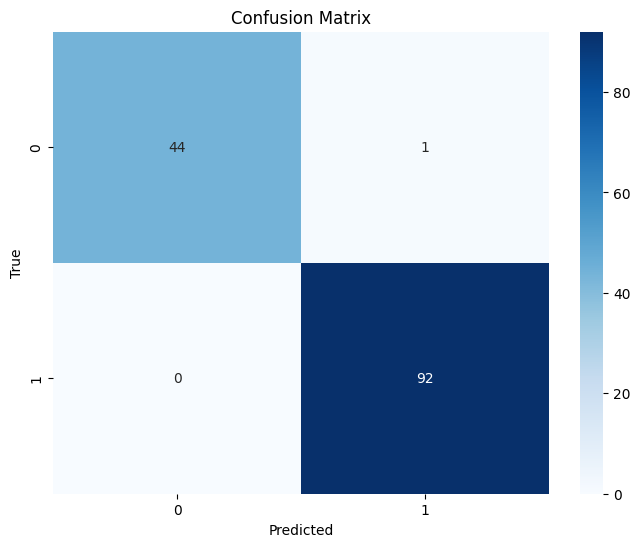

In [ ]:
# Confusion Matrix (혼동 행렬)

# 모델로부터 테스트 데이터 예측 얻기
model.eval()
all_predictions = []
all_targets = []

for inputs, targets in test_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    all_predictions.extend(predicted.cpu().numpy())
    all_targets.extend(targets.cpu().numpy())

# 혼동 행렬 생성
conf_matrix = confusion_matrix(all_targets, all_predictions)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#6. 오답 이미지

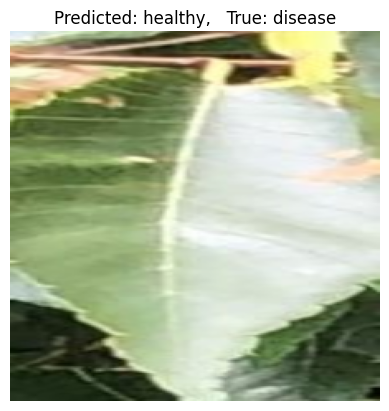

In [ ]:
class_names = ['disease', 'healthy']

misclassified_indices = np.where(np.array(all_predictions) != np.array(all_targets))[0]
misclassified_data = [(test_dataset[i][0], class_names[all_predictions[i]], class_names[all_targets[i]]) for i in misclassified_indices]

mean = np.array([0.45069408, 0.5465592, 0.3197296])
std = np.array([0.064935476, 0.05709109, 0.10717873])

for i, (image, predicted, target) in enumerate(misclassified_data):
    plt.subplot(1, len(misclassified_data), i + 1)
    image = image * std.reshape(-1, 1, 1) + mean.reshape(-1, 1, 1)
    image = np.clip(image, 0, 255)
    plt.imshow(image.numpy().transpose((1, 2, 0)))
    plt.title(f"Predicted: {predicted},   True: {target}")
    plt.axis('off')

plt.show()

# 총평

**데이터 처리**
이미지에 라벨을 부여하고, 3D 텐서로 전환
train, validation, test 3가지 datasets로 구분하여 처리함

train 데이터 셋
train_dataset = ImageFolder(root=train_data_path, transform=train_transform) # train_data_path, train_transform

val 데이터 셋
val_dataset = ImageFolder(root=train_data_path, transform=test_transform) # train_data_path, test_transform

test 데이터 셋
test_dataset = ImageFolder(root=test_data_path, transform=test_transform) # test_data_path, test_transform


**모델**
-> resnet 채택, 모델의 장점
-> IMAGENET1K_V2에서 사전 학습한 모델을 사용
-> resnet50을 기준으로 전이학습의 성능을 비교
-> 0.7883에서 0.9562로 성능 향상

-> 다른 resnet 모델은 어떨까??
-> resnet50, resnet101, wide resnet50, wide resnet101로
-> 사전 학습한 경우의 모델 성능 비교
->  resnet 101의 성능이 가장 좋았음(0.9781), 나머지(0.9708)


**손실함수, 옵티마이저, 스케줄러 및 하이퍼 파라미터**
-> loss_fn = nn.CrossEntropyLoss(label_smoothing=0.01)
-> optimizer = optim.AdamW(model.parameters()
-> betas=(0.9, 0.999), eps=1e-08, weight_decay=0.05, amsgrad=True)
-> scheduler = CosineAnnealingLR(optimizer, T_max= epochs*len(train_loader))
-> lr=0.00001
-> batch_size = 32
-> epochs = 45


**성능 개선을 위한 노력**
0) 원본 이미지의 배경을 지우고 훈련 이미지로 추가하기 -> 원하는 데로 배경이 지워지지 않음 -> 실패

1) 데이터 증강 기법
-> 원본 이미지에 큰 영향을 주지 않는 선에서 증강 기법을 선정함
-> 이미지의 큰 왜곡으로
    T.RandomVerticalFlip(p=0.3),
    T.RandomHorizontalFlip(p=0.3),
    T.RandomRotation(degrees=10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),

2) 픽셀 정규화(Normalize)
-> train과 test데이터를 각 체널별로 픽셀값을 정규화함
-> 0.9562에서 0.9708로 성능이 향상됨

3) 학습이 완료된 모델에 label_smoothing=0.001로 변경하고, lr=0.00001로 변경하여 5 epoch 만큼 추가 학습을 진행
-> 0.9781에서 0.9927로 성능이 향상됨
(model, test_model을 분리함)